In [77]:
import sys
sys.path.insert(0, "..")
import pandas as pd
import h5py
from validator_tests.utils.constants import TARGET_ACCURACY
import umap
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler

In [2]:
df1 = pd.read_pickle()
df2 = pd.read_pickle()
df = pd.concat([df1, df2], axis=0)

In [108]:
acc_mask = (df[TARGET_ACCURACY]<0.7) & (df[TARGET_ACCURACY]>0.3)
ami_mask = (df["validator"] == "ClassAMICentroidInit") & (df["validator_args"] == '{"layer": "features", "normalize": true, "p": 2.0, "split": "train", "with_src": true}') & (df["score"] < 0.5)
ss_mask = (df["validator"] == "ClassSSCentroidInit") & (df["validator_args"] == '{"layer": "features", "normalize": true, "p": 2.0, "split": "train", "with_src": true}') & (df["score"] > 0.5)
cols = ["adapter", "exp_name", "trial_num", "epoch", "feature_layer", TARGET_ACCURACY]
x = df[acc_mask & ami_mask][[*cols, "score"]]
y = df[acc_mask & ss_mask][[*cols, "score"]]
z = x.merge(y, on=cols)
z


,adapter,exp_name,trial_num,epoch,feature_layer,target_train_micro,score_x,score_y
0,IMConfig,im,61,50,6,0.32091,0.316605,0.551953


In [58]:
features = h5py.File(, 'r')

In [80]:
src_features = features['10/inference/src_train/features']
target_features = features['10/inference/target_train/features']
src_labels = features['10/inference/src_train/labels']
target_labels = features['10/inference/target_train/labels']
all_features = np.concatenate([src_features, target_features], axis=0)
all_labels = np.concatenate([src_labels, target_labels], axis=0)

# transformed_features = umap.UMAP().fit_transform(all_features)

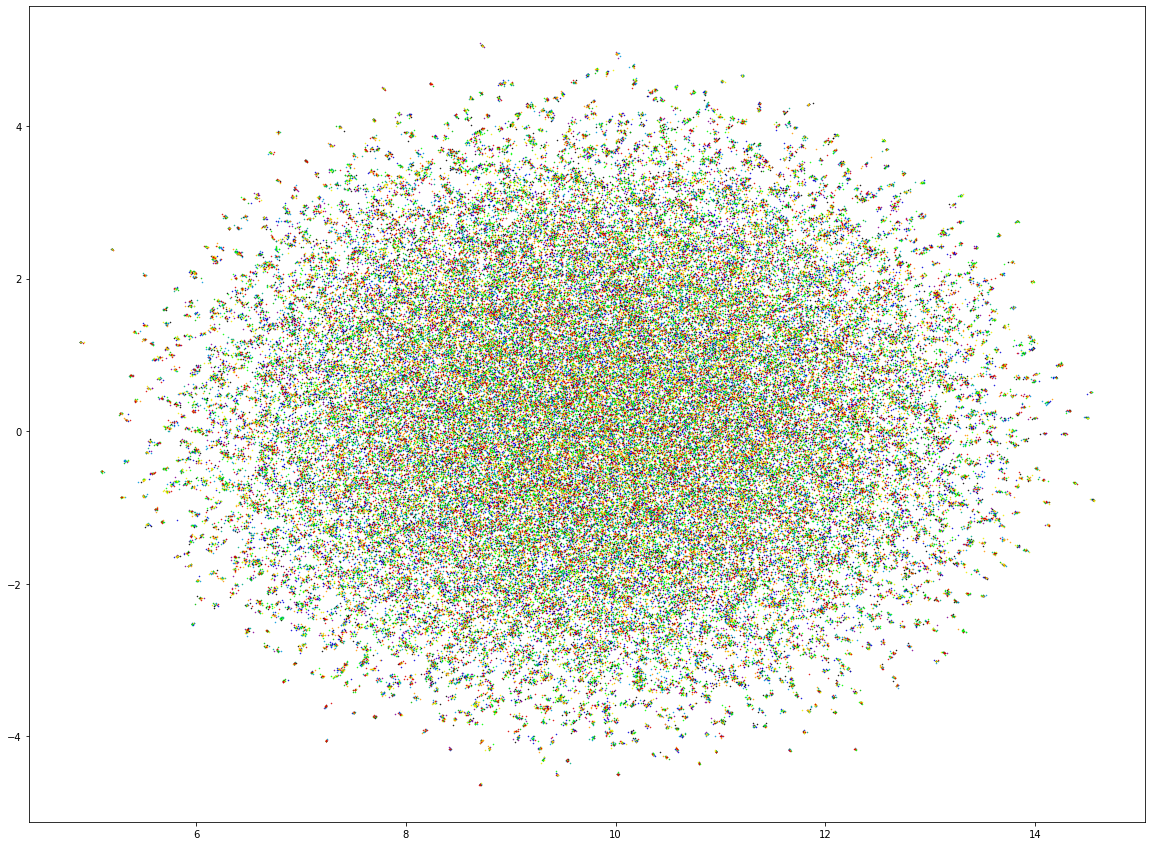

In [78]:
def plot_umap(umap_embeddings, labels):
    label_set = np.unique(labels)
    num_classes = len(label_set)
    plt.figure(figsize=(20, 15))
    plt.gca().set_prop_cycle(
        cycler(
            "color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]
        )
    )
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)
    plt.show()

plot_umap(transformed_features, all_labels)

/tmp/ipykernel_626015/3247101431.py:19: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  clustering.fit(all_features)


unique cluster labels [1 2 3 4 5]
[5 5 5 ... 5 5 5]


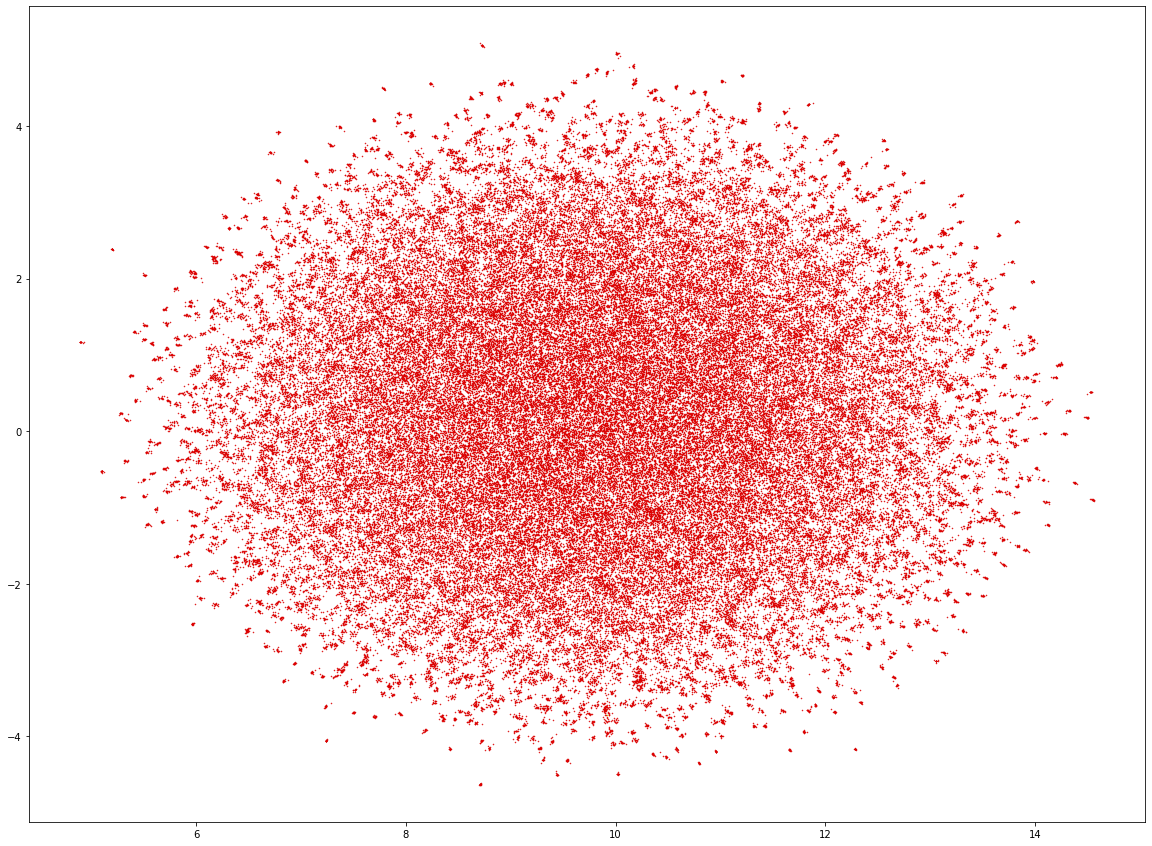

In [95]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score, silhouette_score

# copied from https://github.com/lr94/abas/blob/master/model_selection.py
def get_centroids(data, labels, num_classes):
    centroids = np.zeros((num_classes, data.shape[1]))
    for cid in range(num_classes):
        # Since we are using pseudolabels to compute centroids, some classes might not have instances according to the
        # pseudolabels assigned by the current model. In that case .mean() would return NaN causing KMeans to fail.
        # We set to 0 the missing centroids
        if (labels == cid).any():
            centroids[cid] = data[labels == cid].mean(0)

    return centroids


centroids = get_centroids(all_features, all_labels, 10)
clustering = KMeans(n_clusters=10, init=centroids, n_init=1)
clustering.fit(all_features)
clabels = clustering.labels_
print("unique cluster labels", np.unique(clabels))
print(clabels[clabels==5])
# silhouette_score(all_features, clabels)
plot_umap(transformed_features, clabels)

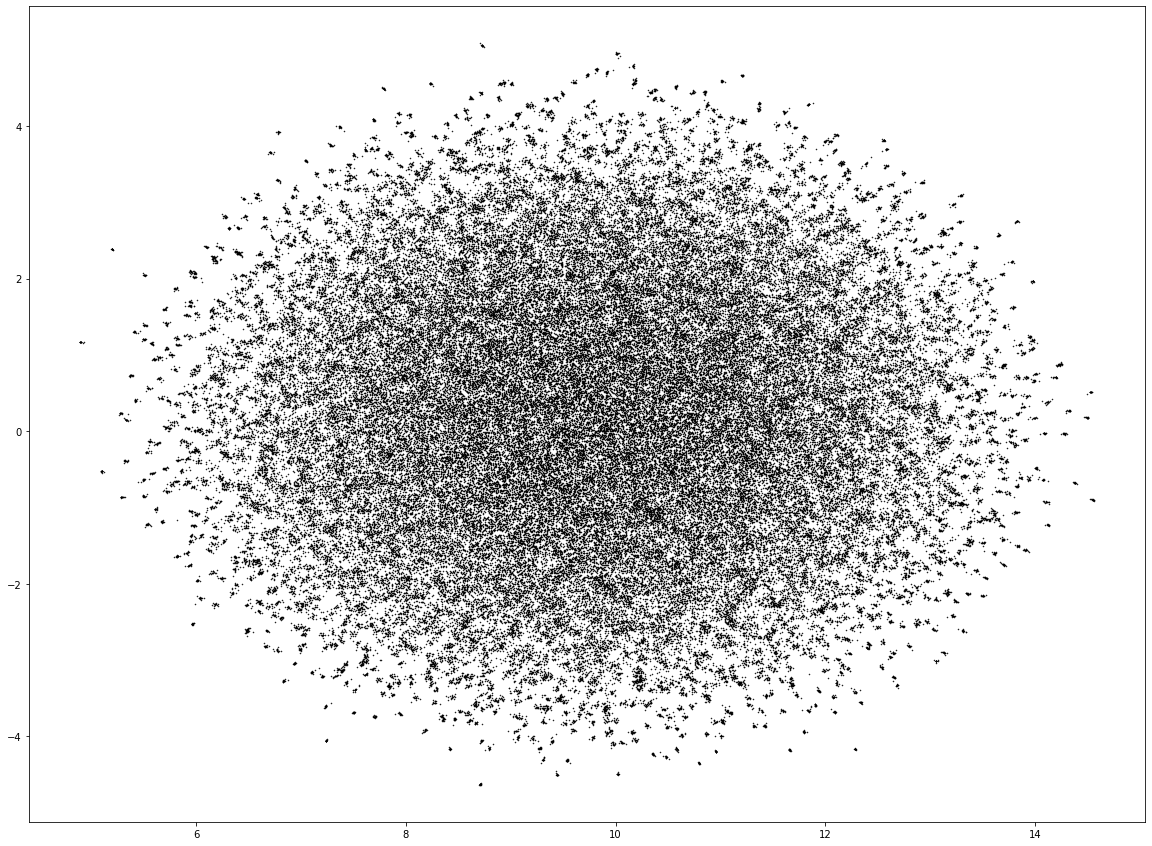

8.330704447234284e-12

In [100]:
src_preds = np.argmax(features['10/inference/src_train/logits'], axis=1)
target_preds = np.argmax(features['10/inference/target_train/logits'], axis=1)
all_preds = np.concatenate([src_preds, target_preds], axis=0)
plot_umap(transformed_features, all_preds)
adjusted_mutual_info_score(all_preds, clabels)